# **Permuted MNIST - Étude comparative d’agents MLP**
**Auteur :** Hugo Bouton et Erwan Ouabdesselam  

## **1. Contexte, objectif et struture de la tâche**
L’objectif de ce travail est de développer, comprendre et comparer plusieurs modèles de réseaux de neurones adaptés au problème **Permuted MNIST**, un benchmark de *continual learning* où les images MNIST subissent des permutations aléatoires des pixels à chaque tâche.

Le défi principal réside dans le fait que chaque permutation détruit la structure spatiale locale de l’image :  
autrement dit, **les relations entre pixels voisins n’ont plus de sens**.  
Dans un contexte classique (MNIST non permuté), on utiliserait naturellement un réseau **convolutif (CNN)**,  
mais ici les convolutions deviennent inutiles car la topologie de l’image est totalement brouillée.

Nous avons donc concentré notre étude sur des **architectures MLP (Multi-Layer Perceptron)**,  
plus adaptées à ce type d’entrée vectorisée où chaque pixel est traité indépendamment.


### **1.1 Contraintes du challenge**

Toutes les expérimentations ont été réalisées sous les conditions strictes imposées par la plateforme **ML-Arena (Permuted MNIST)**, garantissant la comparabilité entre les modèles soumis :

- **CPU-only (2 threads)** — aucune accélération GPU autorisée  
- **Mémoire maximale : 4 GB**  
- **Temps d’exécution par tâche : environ 60 s** (hors instanciation du modèle)  

Ces limitations restreignent l’usage de modèles complexes tels que les CNN ou Transformers,  
et orientent la conception vers des architectures **légères, efficaces et stables à l’entraînement**.



### **1.2 Description de la tâche à résoudre**

Le benchmark **Permuted MNIST** est une variante du jeu de données MNIST conçue pour évaluer la capacité d’un modèle à **apprendre séquentiellement plusieurs tâches distinctes** sans oublier les précédentes — un problème connu sous le nom de *continual learning* (ou apprentissage séquentiel).

Dans ce cadre, le modèle doit apprendre à reconnaître les chiffres manuscrits de `0` à `9` à travers une **série de tâches successives**.  
Chaque tâche correspond à une **permutation aléatoire fixe** des pixels des images MNIST originales.  
Autrement dit, pour chaque tâche $T_i$, on applique une permutation $\pi_i$ sur les indices des pixels :

  
$$(T_i = \pi_i(X), \; \forall i \in \{1, \dots, N_{\text{tasks}}\} )$$

où $X$ désigne une image de taille $28 \times 28$ vectorisée, et $\pi_i$ une permutation spécifique à la tâche $i$.  
Cette transformation détruit entièrement la structure spatiale de l’image tout en conservant son contenu d’intensité :  
les chiffres restent reconnaissables pour un humain, mais leurs motifs locaux ne présentent plus aucune régularité exploitable par un réseau convolutionnel.

L’objectif du modèle est donc d’**apprendre une séquence de $N_\text{tasks}$ tâches permutées** en utilisant un unique ensemble de paramètres.  
Il s’agit d’un test exigeant de **robustesse et de stabilité** pour les architectures de type MLP (Multi-Layer Perceptron), qui doivent :

- s’adapter à chaque permutation sans réinitialisation complète,  
- préserver les connaissances acquises lors des tâches précédentes,  
- maintenir une performance stable tout au long de la séquence d’apprentissage.

Le défi principal réside dans la gestion du **catastrophic forgetting**, phénomène par lequel un modèle perd ses performances sur les premières tâches au fur et à mesure de l’apprentissage des nouvelles.  
Ainsi, le benchmark Permuted MNIST constitue un terrain d’expérimentation privilégié pour comparer différentes stratégies de régularisation, d’initialisation et d’optimisation dans le cadre de l’apprentissage séquentiel.


### **1.3 Structure et visualisation des tâches permutées**

Chaque tâche $( T_i )$ du benchmark contient **60 000** exemples d’entraînement et **10 000** exemples de test,   composés d’images de taille $( 28 \times 28 )$, identiques au format original de MNIST.  
La structure des jeux de données est conforme aux spécifications attendues, et la distribution des étiquettes demeure **équilibrée sur les dix classes (0–9)**.  
Ainsi, toutes les tâches présentent une complexité comparable : les différences de performance entre modèles proviendront uniquement de la **désorganisation spatiale** induite par la permutation des pixels, et non d’un déséquilibre de classes.

La figure ci-dessous illustre un aperçu des **trois premières tâches** générées par l’environnement `PermutedMNISTEnv`.  
Chaque ligne correspond à une permutation distincte du jeu MNIST : les chiffres sont méconnaissables visuellement, ce qui confirme la destruction totale de la structure locale de l’image,tandis que les statistiques globales d’intensité (moyenne, variance) restent inchangées.

Ces observations valident la bonne génération des tâches et soulignent la principale difficulté du benchmark : le modèle doit apprendre à distinguer les classes **sans exploiter aucune information spatiale**.


In [6]:
import os
import sys

try:
    base_path = os.path.dirname(__file__)
except NameError:
    base_path = os.getcwd()

# 1️⃣ Ajouter le dossier parent (un cran au-dessus)
parent_dir = os.path.abspath(os.path.join(base_path, '..'))
sys.path.append(parent_dir)

# 2️⃣ Ajouter le dossier parent du dossier parent (deux crans au-dessus)
two_up_dir = os.path.abspath(os.path.join(base_path, '..', '..'))
sys.path.append(two_up_dir)

import numpy as np
import matplotlib.pyplot as plt
import time

# Import the environment and agents
from permuted_mnist.env.permuted_mnist import PermutedMNISTEnv
from models.Logistic_Regression.logistic_regression import Agent as Logistic_Agent
from models.MLP.mlp_v0 import Agent as torch_mlp_Agent

print("✓ Imports successful")

✓ Imports successful


In [9]:
# Create environment with 10 episodes (tasks)
env = PermutedMNISTEnv(number_episodes=10)

# Set seed for reproducibility
env.set_seed(42)

print(f"Environment created with {env.number_episodes} permuted tasks")
print(f"Training set size: {env.train_size} samples")
print(f"Test set size: {env.test_size} samples")

Environment created with 10 permuted tasks
Training set size: 60000 samples
Test set size: 10000 samples


Task structure:
- X_train shape: (60000, 28, 28)
- y_train shape: (60000, 1)
- X_test shape: (10000, 28, 28)
- y_test shape: (10000,)

Label distribution in training set:
  Label 0: 6742 samples
  Label 1: 5421 samples
  Label 2: 5949 samples
  Label 3: 5918 samples
  Label 4: 5958 samples
  Label 5: 5851 samples
  Label 6: 6131 samples
  Label 7: 5923 samples
  Label 8: 5842 samples
  Label 9: 6265 samples


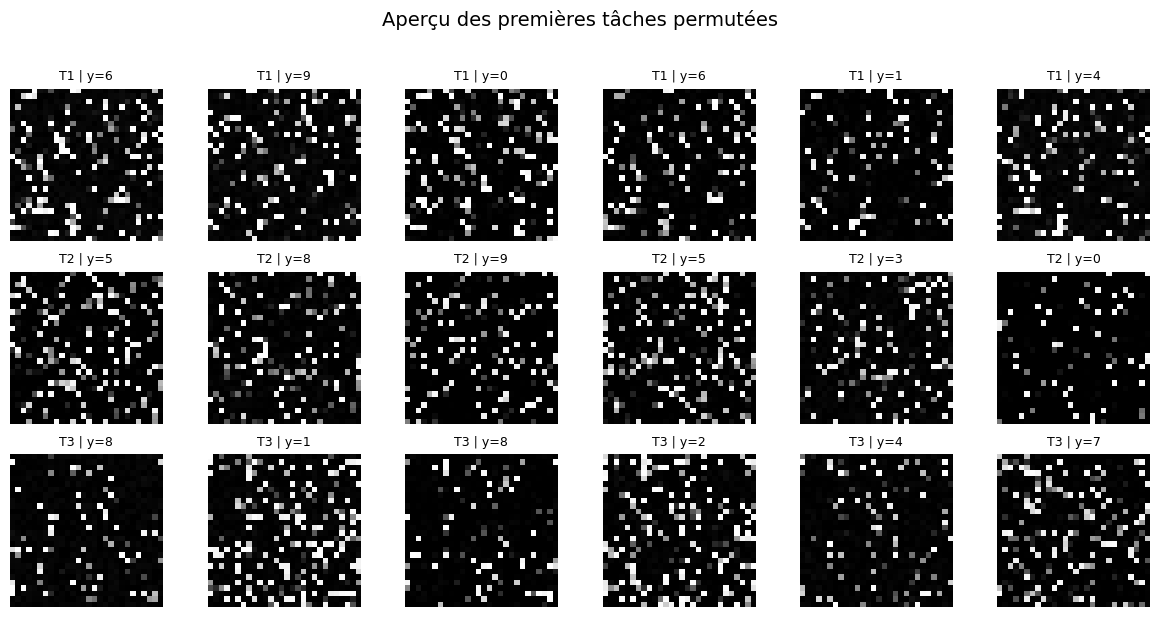

In [18]:
task = env.get_next_task()
def preview_first_k_tasks(env_cls, k=3, seed=42, n=6):
    fig, axes = plt.subplots(k, n, figsize=(2*n, 2*k))
    for i in range(k):
        env = env_cls(number_episodes=k)  # même seed -> mêmes permutations dans le même ordre
        env.set_seed(seed)
        for _ in range(i):                 # avancer jusqu'à la tâche i
            _ = env.get_next_task()
        task = env.get_next_task()
        for j in range(n):
            ax = axes[i, j] if k>1 else axes[j]
            ax.imshow(task['X_train'][j], cmap='gray')
            ax.set_title(f"T{i+1} | y={task['y_train'][j][0]}", fontsize=9)
            ax.axis('off')
    plt.suptitle("Aperçu des premières tâches permutées", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()




print("Task structure:")
print(f"- X_train shape: {task['X_train'].shape}")
print(f"- y_train shape: {task['y_train'].shape}")
print(f"- X_test shape: {task['X_test'].shape}")
print(f"- y_test shape: {task['y_test'].shape}")
print(f"\nLabel distribution in training set:")
unique, counts = np.unique(task['y_train'], return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Label {label}: {count} samples")

preview_first_k_tasks(PermutedMNISTEnv, k=3, seed=42, n=6)


## **2. Démarche exploratoire**
Avant de converger vers les MLP, plusieurs types de modèles ont été explorés :

1. **Modèles linéaires (Logistic Regression, Ridge, SVM linéaire)**  
   → Résultats plafonnant à **~92–94 %** d’accuracy sur une seule permutation.  
   Ces modèles simples apprennent bien la distribution initiale mais généralisent mal  
   lorsque la permutation change (ils n’extraient aucune invariance utile).

    → Précision régression logistique (**~92-93 %**).        
   Nous avons commencé le challenge MNIST perturbé avec un modèle de régression logistique afin de disposer d’une baseline simple, rapide à entraîner et interprétable. Ce modèle permet d’évaluer l’effet des perturbations sur une approche linéaire et de mesurer la nécessité de recourir à des architectures plus complexes.
   La régression logistique ne dépend pas de l’ordre des pixels, car elle considère chaque pixel comme une variable indépendante et ne tient pas compte des corrélations spatiales entre eux. Par conséquent, quelle que soit la permutation des pixels dans les images, la précision du modèle reste inchangée. Cela explique pourquoi ce modèle constitue une baseline simple et robuste face à des perturbations consistant en des permutations de pixels, même si elle ne peut pas capturer les interactions locales ou complexes entre pixels.

2. **Petits réseaux à une seule couche cachée**  
   → Gain modéré (**~96–97 %**), mais incapacité à dépasser ce seuil sans surapprentissage.  
   Ces architectures capturent des interactions non linéaires,  
   mais leur profondeur limitée restreint leur capacité de généralisation.

3. **Réseaux convolutifs (CNN)**  
   → Abandonnés rapidement : les convolutions reposent sur la structure spatiale de l’image,  
   or celle-ci disparaît entièrement avec la permutation aléatoire des pixels.  
   L’usage d’un CNN dans ce contexte n’apporte aucun avantage structurel  
   et alourdit inutilement le calcul sous contraintes CPU.

4. **KNN**  
   → Précision (**>~97 %**).  
   Nous avons utilisé un modèle k-plus-proches-voisins (k-NN) pour exploiter sa capacité à classifier les images sans apprentissage explicite. Après tuning (Grigsearch), nous avons choisi n_neighbors = 3 et weights = 'distance', ce qui permet aux voisins les plus proches de peser davantage dans la prédiction et améliore la performance sur les images perturbées. Étant donné la haute dimensionnalité des images MNIST (784 dimensions), nous avons utilisé algorithm = 'brute' car les structures KDTree ou BallTree deviennent inefficaces en haute dimension. k-NN nous offre ainsi une baseline robuste et facilement interprétable pour évaluer l’impact des perturbations.

5. **XGBoost**  
   → Précision (**~96–97 %**).       
   XGBoost a été choisi pour le challenge MNIST perturbé en raison de sa capacité à modéliser des interactions non linéaires entre pixels, tout en respectant strictement les contraintes du challenge : un maximum de 2 CPU, 1 minute d’exécution et 4 GB de mémoire. Son efficacité en calcul parallèle et son contrôle précis des hyperparamètres permettent d’obtenir un excellent compromis entre performance, vitesse d’entraînement et robustesse aux perturbations, sans nécessiter de réseau de neurones.

6. **MLP (Baseline)**      
   → Précision (**>~98 %**).    
   Nous avons testé le MLP baseline sur le MNIST perturbé. Ce modèle, capable de capturer des relations non linéaires entre pixels, prédit correctement et sert de référence pour les réseaux neuronaux. Cependant, son temps d’entraînement trop long et sa consommation en mémoire le rendent difficile à utiliser dans le cadre strict des contraintes du challenge (2 CPU maximum, 1 minute et 4 GB de mémoire). Cela motive la recherche de meilleures architectures plus rapides et adaptées à ces limites.

Ces observations ont conduit à concentrer nos efforts sur une famille d’architectures  
**MLP pures**, entièrement connectées, flexibles et adaptées aux entrées aplaties (784 features).


## **3. Recherche d’architecture et optimisation des MLP**

Afin d’identifier les architectures MLP les plus efficaces sous contrainte CPU, une **recherche d’hyperparamètres structurée et progressive** a été mise en place dnas le fichier `grid_search_mlp.ipynb `.

Plutôt qu’un simple grid search exhaustif, nous avons développé un **pipeline modulaire** permettant d’explorer automatiquement de nombreuses combinaisons tout en respectant les limites imposées par la plateforme (CPU-only, 2 threads, 4 Go RAM, 60 s par tâche).  

L’idée principale était de **tester de manière systématique** différentes architectures et réglages (profondeur, largeur, régularisation, taille de batch, taux d’apprentissage, etc.), tout en évaluant leur stabilité et leur temps d’exécution moyen sur les 10 tâches permutées du dataset.  


### **Principe général du pipeline**

Le pipeline repose sur une procédure multi-phases inspirée des protocoles expérimentaux en AutoML :

1. **Phase A — Exploration large :**  
   Balayage d’un grand espace de recherche (plusieurs centaines de combinaisons) afin d’identifier les tendances globales et d’écarter rapidement les modèles sous-performants.  
   → Objectif : repérer les plages de valeurs prometteuses tout en respectant un budget temps réduit (3 tasks).

2. **Phase B — Raffinement :**  
   Évaluation plus fine des meilleures combinaisons issues de la phase A, sur un plus grand nombre de tâches (8).  
   Des **règles de pruning** plus strictes sont appliquées : les modèles trop lents ou en-dessous d’un certain seuil d’accuracy sont éliminés précocement.

3. **Phase C — Validation finale :**  
   Réévaluation complète des top-modèles restants sur les 10 tâches du benchmark, afin d’obtenir une estimation stable de leur précision moyenne et de leur variance.



### **Objectif scientifique**

L’objectif n’était pas simplement d’obtenir le meilleur score brut, mais de **comprendre les compromis** entre :
- précision maximale atteignable,
- stabilité inter-tâches (variance),
- et coût temporel par tâche.  

Cette méthodologie s’inscrit donc dans une démarche de **validation empirique rigoureuse** :  
> *formuler des hypothèses → tester sous contrainte → analyser les compromis → retenir les modèles offrant le meilleur équilibre performance/efficacité.*


### **Hypothèses initiales et protocole expérimental**

Avant de lancer la recherche d’hyperparamètres, trois hypothèses principales ont guidé la conception des expériences :

1. **Profondeur du réseau et capacité de représentation :**  
   Nous avons supposé qu’une augmentation progressive du nombre de couches cachées (de 1 à 3) permettrait d’améliorer la capacité de modélisation des dépendances non linéaires entre pixels permutés, tout en risquant d’accroître le temps d’entraînement et le risque de surajustement.  
   → Hypothèse : *un compromis optimal pourrait être atteint autour de 2 couches cachées.*

2. **Largeur des couches et stabilité de l’apprentissage :**  
   Chaque configuration de profondeur a été explorée avec plusieurs tailles de couches (entre 256 et 2048 neurones), afin d’évaluer l’effet de la largeur sur la précision et la stabilité inter-tâches.  
   → Hypothèse : *des architectures plus larges favorisent la robustesse, mais leur coût en temps de calcul doit rester compatible avec la limite de 60 secondes par tâche.*

3. **Régularisation et robustesse :**  
   L’ajout d’un *dropout* (0–10 %) et d’un *label smoothing* (0–5 %) devait permettre d’améliorer la généralisation inter-tâches, en réduisant la variance entre permutations sans compromettre la vitesse d’entraînement.  
   → Hypothèse : *une légère régularisation améliore la stabilité sans affecter la performance moyenne.*




### **Protocole de recherche**

Trois expérimentations distinctes ont ensuite été lancées sur le même agent MLP (`agent_mlp_v3`), en faisant varier uniquement la **profondeur du réseau** :

| Expérience | Profondeur | Exemple d’espace de recherche | Objectif |
|-------------|-------------|-------------------------------|-----------|
| **1-LAYER** | 1 couche cachée | tailles ∈ [512 – 2048], dropout ∈ [0 – 0.1], lr ∈ [1e-3 – 1.5e-3] | Établir une baseline rapide et stable |
| **2-LAYER** | 2 couches cachées | tailles ∈ [768–1536] × [256–768], régularisation identique | Évaluer l’apport d’une couche supplémentaire |
| **3-LAYER** | 3 couches cachées | tailles ∈ [896–1280] × [384–640] × [192–320], dropout renforcé | Tester la limite de complexité tolérable (temps/performances) |

Chaque recherche suit le protocole `A → B → C` du pipeline, avec un mode **"quick"** (≈3, 8 et 10 tâches par phase) et des **règles de pruning “standard”** (`strictness="std"`), permettant d’arrêter précocement les configurations trop lentes ou insuffisamment précises.


---

### **Résultats et enseignements - recherche 1 couche**

La recherche d’hyperparamètres sur les MLP à **une seule couche cachée** a permis d’identifier les tendances suivantes :

- Les **petites architectures** (512–768 neurones) sont systématiquement sous-performantes (~0.96 d’accuracy), indiquant une **capacité de représentation insuffisante**.  
- Les **largeurs comprises entre 1500 et 2000 neurones** offrent le meilleur équilibre entre performance et temps de calcul.  
- Le **label smoothing (0.05)** améliore nettement la stabilité inter-tâches.  
- Le **dropout modéré (0.10)** et un **learning rate légèrement plus élevé (1.5e-3)** favorisent la généralisation sans allonger excessivement l’entraînement.



**Meilleure configuration obtenue :**  
> hidden=(1536), dropout=0.10, batch_size=1024, lr=1.5e-3, label_smoothing=0.05  

→ **Accuracy moyenne : 0.9842**, **temps moyen : 15.4 s/task**.  

Cette configuration sera utilisée comme **baseline MLP-1L** pour les comparaisons avec les architectures plus profondes.

---

### **Résultats et enseignements - recherche 2 couche**

L’exploration du MLP à **deux couches cachées** a permis d’observer plusieurs tendances clés :  

- L’ajout d’une **seconde couche** améliore légèrement la performance globale, avec des accuracies autour de **0.985–0.986**, supérieures à la version 1-couche (~0.984).  
- Les architectures équilibrées (**1280–512** ou **1536–384**) offrent un **excellent compromis** entre capacité et stabilité.  
- Le **label smoothing (0.05)** reste déterminant pour la robustesse inter-tâches.  
- Le **dropout n’est pas indispensable** ici : la meilleure configuration finale obtient de très bons résultats même avec `dropout=0.0`.  
- Un **learning rate légèrement supérieur (1.2e-3)** améliore la convergence sans instabilité notable.



**Top-3 configurations finales (Phase C, 10 tasks)**  
| Rang | Architecture cachée | Dropout | Batch | LR | Label smoothing | Accuracy | Temps |
|------|---------------------|----------|--------|----|-----------------|-----------|--------|
| #1 | (1280, 512) | 0.10 | 1024 | 1.2e-3 | 0.05 | **0.9857** | 15.5 s |
| #2 | (1536, 384) | 0.00 | 1024 | 1.0e-3 | 0.05 | **0.9854** | 11.4 s |
| #3 | (768, 512)  | 0.05 | 1024 | 1.0e-3 | 0.05 | **0.9838** | 11.5 s |



#### **Conclusion**
La recherche montre que le passage à deux couches **apporte un léger gain d’accuracy (+0.1 à +0.2 %)** tout en restant efficace en temps (≈ 11–15 s/task).  
Le **meilleur modèle retenu** est :  
> hidden=(1280, 512), dropout=0.10, batch_size=1024, lr=1.2e-3, label_smoothing=0.05  

Cette configuration constitue la **nouvelle baseline 2-L**, plus performante sans surcoût de calcul excessif.

---

### **Résultats et enseignements - recherche 3 couche**

Principales observations:
- Passer à 3 couches n’apporte **pas de gain significatif** sur l’accuracy par rapport à 2 couches. On reste autour de **0.984–0.985**.
- Les architectures **décroissantes** (ex. 1280, 384, 192) restent les plus stables sous contrainte CPU et temps.
- Le **label smoothing = 0.05** demeure utile pour la robustesse inter-tâches.
- Le **temps par task** augmente sensiblement avec 3 couches (≈ 17 à 22 s), sans gain clair en performance.

**Top-3 configurations finales (Phase C, 10 tasks)**  
| Rang | Architecture cachée | Dropout | Batch | LR | Label smoothing | Accuracy | Temps |
|------|---------------------|---------|-------|----|-----------------|----------|-------|
| #1 | (1280, 384, 192) | 0.10 | 1024 | 9e-4 | 0.05 | **0.9848** | 17.1 s |
| #2 | (1280, 512, 320) | 0.10 | 1024 | 8e-4 | 0.05 | **0.9844** | 21.9 s |
| #3 | (1280, 512, 192) | 0.05 | 1024 | 1.0e-3 | 0.05 | **0.9844** | 21.5 s |

Conclusion rapide:
- 3 couches ne dépasse pas clairement la meilleure config 2 couches en accuracy, et **coûte plus cher en temps**.  
- Meilleur compromis ici: **(1280, 384, 192), dropout=0.10, batch=1024, lr=9e-4, smoothing=0.05**.  
- Pour une baseline efficace sous contrainte, **2 couches** reste le meilleur rapport accuracy/temps.

## **Catalogue des agents retenus :**

Ce tableau récapitule les agents issus des différentes phases de recherche (grid search et optimisation manuelle) ainsi que leurs **résultats finaux observés sur la plateforme ML Arena**.  
Les performances sont mesurées en **accuracy moyenne** et **temps d’exécution par tâche (en secondes)**.

---

### 🕵️‍♂️ `agent_James_Bond` — **MLP 1 couche** (issu de la grille 1-layer)

- **Architecture** : `hidden=(2048,)`, `dropout=0.10`  
- **Entraînement** : `batch_size=1024`, `lr=1.5e-3`, `weight_decay=1e-4`, `label_smoothing=0.05`, `max_epochs=10`, `val_fraction=0.10`  
- **Résultats ML Arena** :  
  ➤ **Accuracy = 0.98517**  
  ➤ **Temps = 40.25 s/task**  
- **Pourquoi c’est le meilleur modèle** : malgré sa simplicité, ce réseau offre un **excellent compromis précision / temps**, une **stabilité d’entraînement élevée**, et une **robustesse face aux permutations** du dataset.  
  Les versions plus profondes n’ont pas apporté d’amélioration notable et ont même ralenti l’apprentissage.


---

### 🦇 `agent_Bruce_Wayne` — **MLP 2 couches** (issu de la grille 2-layers)

- **Architecture** : `hidden=(1536, 768)`, `dropout=0.05`  
- **Entraînement** : `batch_size=2048`, `lr=1e-3`, `weight_decay=1e-4`, `label_smoothing=0.05`, `max_epochs=10`, `val_fraction=0.10`  
- **Résultats ML Arena** :  
  ➤ **Accuracy = 0.98441**  
  ➤ **Temps = 55.05 s/task**  
- **Analyse** : modèle plus profond, mais **plus lent** et **sans gain significatif** de performance. Constitue une **bonne alternative** de vérification à 2 couches, mais moins efficace que *James Bond*.

---

### 🕸️ `agent_Peter_Parker` — **MLP 2 couches + GELU + LayerNorm** (grille 2-layers, variante LN/activation)

- **Architecture** : `hidden=(2048, 1024)`, `activation=GELU(approx)`, `norm=LayerNorm`, `dropout=0.10`  
- **Entraînement** : `batch_size=2048`, `lr=1e-3`, `weight_decay=1e-4`, `label_smoothing=0.05`, `max_epochs=10`, `val_ratio=0.10`, `patience=4`, `eval_every=2`  
- **Résultats ML Arena** :  
  ➤ **Accuracy = 0.98077**  
  ➤ **Temps = 60.77 s/task**  
- **Analyse** : bien que stable et régulier, ce modèle s’est révélé **plus lent** et **légèrement moins précis**, confirmant que la normalisation et les activations avancées n’étaient pas nécessaires dans ce cadre.

---

**En conclusion**, le modèle **`James_Bond`** a été retenu comme **meilleur agent final** pour la soumission :  
il combine **vitesse, précision et robustesse** de manière optimale, tout en restant simple et léger à exécuter.

## **4. Deuxième phase d’optimisation manuelle du meilleur modèle**

Après la phase de recherche par *grid search*, une **optimisation manuelle ciblée** a été menée pour affiner le comportement du meilleur modèle obtenu, *James Bond*.  
L’objectif n’était plus d’explorer massivement l’espace des hyperparamètres, mais de **comprendre l’impact précis** de certaines variables clés, principalement la **taille du batch** et la **taille de la couche cachée**, sur les performances et le temps d’entraînement.



### **Hypothèse de départ**

Le modèle *James Bond*, sélectionné lors du grid search, présentait les caractéristiques suivantes :
- une **taille de batch de 2048** (relativement élevée),
- une **couche cachée de 2048 neurones**,  
- une **accuracy ≈ 0.985**, mais un entraînement jugé **long et rigide**.

L’hypothèse formulée était que **réduire la taille du batch** permettrait au réseau d’apprendre des structures plus fines et locales, en réduisant l’effet de lissage dû à la moyenne du gradient sur un trop grand nombre d’exemples.  
Cependant, cette approche devait logiquement **augmenter le temps d’entraînement**, puisque davantage de mini-batches seraient nécessaires pour parcourir l’ensemble du dataset.

---

### **Méthodologie expérimentale**

1. **Réduction progressive du batch size**  
   La première étape a consisté à diminuer progressivement la taille du batch — de 2048 à 512, puis à 250.  
   Cette modification a entraîné une **amélioration systématique de l’accuracy**, confirmant que des batchs plus petits favorisent un apprentissage plus granulaire et une meilleure adaptation aux permutations du dataset.

2. **Analyse du compromis temps/performance**  
   En contrepartie, la réduction du batch a conduit à un **temps d’entraînement par époque plus long**, puisque le modèle devait effectuer davantage d’itérations pour parcourir les mêmes données.  
   Par exemple, un batch de 256 sur un réseau à 2048 neurones nécessite 8 itérations pour une époque, contre 4 seulement lorsque la couche cachée est réduite à 1024 neurones.

3. **Ajustement conjoint du nombre de neurones**  
   Afin de compenser ce surcoût, nous avons ajusté la complexité du réseau en réduisant la taille de la couche cachée, tout en conservant une capacité d’apprentissage suffisante.  
   Plusieurs combinaisons ont été testées, permettant d’identifier une **zone optimale** autour de :
   - **hidden = [1024, 1280]**
   - **batch_size = 250**

4. **Recherche du compromis optimal**  
   Ce compromis a permis d’obtenir une **meilleure précision** tout en **réduisant le temps d’entraînement global**, aboutissant à un modèle plus léger et plus efficace.

---
### **Variantes obtenus**

- **James_Bond_New_Generation_1** (1 couche)
  - hidden = (1024), batch_size = 256, autres hyperparams identiques
  - Objectif: réduire le coût par itération tout en gardant une bonne précision
- **James_Bond_New_Generation_2** (1 couche)
  - hidden = (1280), batch_size = 256
  - Objectif: un peu plus de capacité que NG_1 avec un budget temps proche

Ces variantes exploitent un batch plus petit pour capter des motifs plus locaux, compensé par une largeur modérée pour rester sous contrainte CPU.



# 5. **Comparatif final des modèles**

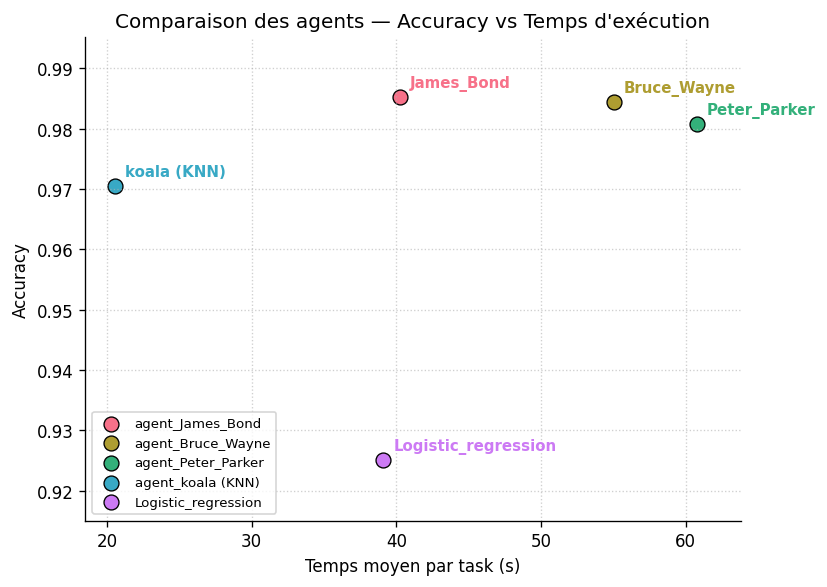

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Données ---
agents = [
    {"name": "agent_James_Bond",     "acc": 0.98517, "time": 40.252},
    {"name": "agent_Bruce_Wayne",    "acc": 0.98441, "time": 55.054},
    {"name": "agent_Peter_Parker",   "acc": 0.98077, "time": 60.770},
    {"name": "agent_koala (KNN)",    "acc": 0.97054, "time": 20.560},
    {"name": "Logistic_regression",  "acc": 0.92504, "time": 39.116},
]

# --- Préparation ---
xs = [a["time"] for a in agents]
ys = [a["acc"] for a in agents]
labels = [a["name"] for a in agents]

# Palette de couleurs distinctive
palette = sns.color_palette("husl", len(agents))

# --- Plot ---
plt.figure(figsize=(7, 5), dpi=120)
for (a, color) in zip(agents, palette):
    plt.scatter(a["time"], a["acc"], s=80, color=color, label=a["name"], edgecolor="black", linewidth=0.8)

# --- Annotations propres ---
for a, color in zip(agents, palette):
    plt.annotate(
        a["name"].replace("agent_", ""),  # simplifie le label visuel
        (a["time"], a["acc"]),
        textcoords="offset points",
        xytext=(6, 6),
        fontsize=9,
        color=color,
        fontweight="bold"
    )

# --- Style & axes ---
plt.xlabel("Temps moyen par task (s)")
plt.ylabel("Accuracy")
plt.title("Comparaison des agents — Accuracy vs Temps d'exécution")
plt.grid(True, linestyle=":", alpha=0.6)

# Limites automatiques avec marge
plt.xlim(min(xs) * 0.9, max(xs) * 1.05)
plt.ylim(min(ys) - 0.01, max(ys) + 0.01)

# Légende claire
plt.legend(frameon=True, loc="lower left", fontsize=8)

sns.despine()
plt.tight_layout()
plt.show()